# Analyze the Normalization Innovation Squared (NIS)


In [210]:
import numpy as np
import matplotlib.pyplot as plt

In [211]:
nis_radar = np.loadtxt("nis_radar.txt",dtype=np.float32)
nis_lidar = np.loadtxt("nis_lidar.txt",dtype=np.float32)

## get 95% percentile of NIS error. 
- For Radar it shall be below 7.82 (degree of freedeom = 3)
- For Lidar it shall be below 6 (degree of freedeom = 2)


In [212]:
np.percentile(nis_radar,95)

7.7295879364013675

In [213]:
np.percentile(nis_lidar,95)

5.0936161041259753

In [214]:
radar_dist = np.histogram(nis_radar,bins=20,range=(0,10))
lidar_dist = np.histogram(nis_lidar,bins=20,range=(0,10))

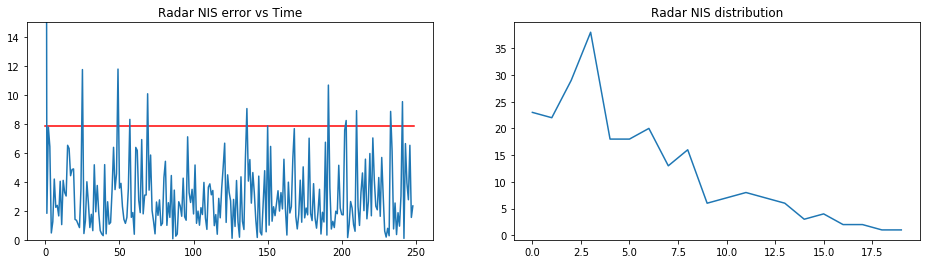

In [215]:
X= np.arange(0,250)
Y3 = np.ones(shape=[250],dtype=np.float32)*7.82

plt.figure(figsize=(16,4))
ax =plt.subplot(1,2,1)
ax.set_title("Radar NIS error vs Time")
ax.set_ylim(0,15)
plt.plot(X,Y3,'r')
plt.plot(nis_radar)
ax= plt.subplot(1,2,2)
ax.set_title("Radar NIS distribution")
plt.plot(radar_dist[0])
plt.show()

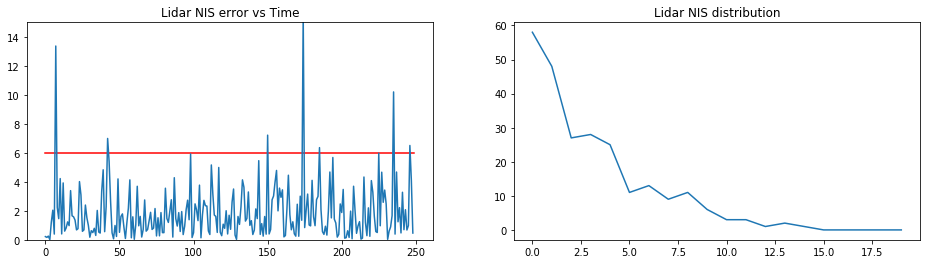

In [216]:
X= np.arange(0,250)
Y3 = np.ones(shape=[250],dtype=np.float32)*6.0

plt.figure(figsize=(16,4))
ax =plt.subplot(1,2,1)
ax.set_title("Lidar NIS error vs Time")
ax.set_ylim(0,15)
plt.plot(X,Y3,'r')
plt.plot(nis_lidar)
ax= plt.subplot(1,2,2)
ax.set_title("Lidar NIS distribution")
plt.plot(lidar_dist[0])
plt.show()

## Estimate the process noise from measured data
the acceleration of v and yaw is approximate to following equation

- nu_yawdd ~ yaw_rate_delta / delta_t
- nu_ a  ~ v_delta / delta_t

In [217]:
import pandas as pd

### read the measure data

In [218]:
file = open("obj_pose-laser-radar-synthetic-input.txt","r")
df=[]
for line in file:
    df.append(line.split()[-7:])

In [219]:
ground_data = pd.DataFrame.from_records(df,columns=["timestamp","px","py","vx","vy","yaw","yaw_rate"])
ground_data["v"] = ground_data["vx"].astype(np.float32).apply(lambda x:x*x) + ground_data["vy"].astype(np.float32).apply(lambda x:x*x)
ground_data["v"] = np.sqrt(ground_data["v"])
ground_data["v_delta"] = ground_data["v"].diff()
ground_data["yaw_rate_delta"] = ground_data["yaw_rate"].astype(np.float32).diff()

## calculate delta t

In [220]:
ground_data["delta_t"] = ground_data["timestamp"].astype(np.int32).diff()/1.0e6

ground_data = ground_data[["delta_t","v_delta","yaw_rate_delta"]]
ground_data.head()

,delta_t,v_delta,yaw_rate_delta
0,NaN,NaN,NaN
1,0.05,-0.000189,0.006910
2,0.05,-0.000316,0.006908
3,0.05,-0.000442,0.006905
4,0.05,-0.000567,0.006900


In [221]:
ground_data["yaw_dd"] = ground_data["yaw_rate_delta"]/ground_data["delta_t"]
ground_data["v_dd"] = ground_data["v_delta"]/ground_data["delta_t"]
ground_data.head()

,delta_t,v_delta,yaw_rate_delta,yaw_dd,v_dd
0,NaN,NaN,NaN,NaN,NaN
1,0.05,-0.000189,0.006910,0.138205,-0.003789
2,0.05,-0.000316,0.006908,0.138161,-0.006311
3,0.05,-0.000442,0.006905,0.138095,-0.008835
4,0.05,-0.000567,0.006900,0.138008,-0.011343


In [222]:
### get the approximate noise range

In [223]:
ground_data["yaw_dd"].var(),ground_data["yaw_dd"].std()

(0.0095535761159203023, 0.097742396716677157)

In [224]:
ground_data["v_dd"].var(),ground_data["v_dd"].std()

(0.0050732613875873814, 0.071226830531671004)

## Further adjust the process noise based on NIS value  